In [6]:
import h5py
import os
from collections import namedtuple
from functools import cache

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from genomic_utils.variant import Variant

In [12]:
VCFS_DIR = "/global/scratch/users/poojakathail/enformer/gtex_fine/vcf"
SAD_SCORES_DIR = "/global/scratch/users/poojakathail/enformer/gtex_fine/preds/"
SUSIE_DIR = "/global/scratch/users/poojakathail/enformer/gtex_fine/susie"
GTEX_GENES_PATH = "/clusterfs/nilah/pooja/genomes/gtex_genes.bed"

In [13]:
DNASE_TRACK_IDXS = {
    "Pancreas": 257,
    "Ovary": 439,
    "Liver": 452,
    "Uterus": 283,
    "Testis": 665,
    "Spleen": 594,
    "Lung": 245,
    "Thyroid": 241,
    "Prostate": 653,
    "Vagina": 382,
    "Stomach": 204,
    "Adrenal_Gland": 265,
    "Cells_EBV-transformed_lymphocytes": 69
}

CAGE_TRACK_IDXS = {
    "Pancreas": 4946,
    "Ovary": 4688,
    "Liver": 4686,
    "Uterus": 4910,
    "Testis": 4694,
    "Spleen": 4693,
    "Lung": 4687,
    "Thyroid": 4696,
    "Prostate": 4690,
    "Vagina": 5175,
    "Stomach": 4959,
    "Adrenal_Gland": 4977,
    "Cells_EBV-transformed_lymphocytes": 5110
}

In [9]:
def get_variants_in_vcf(vcf_path) -> set[str]:
    variant_ids = set()
    for line in open(vcf_path, "r"):
        if line.startswith("#"):
            continue
        row = line.strip().split("\t")
        variant_ids.add(row[2])
    return variant_ids


def load_susie_df(tissue: str, pos_variants: set[str], neg_variants: set[str]) -> pd.DataFrame:
    susie_path = os.path.join(SUSIE_DIR, f"{tissue}.tsv")
    susie_df = pd.read_csv(susie_path, sep="\t", header=0, index_col=0)
    
    # Subset to variants in the VCF 
    variants = pos_variants | neg_variants
    susie_df = susie_df[susie_df["variant"].isin(variants)].copy()
    assert len(variants) == len(set(susie_df["variant"]))
    
    susie_df["finemapped"] = susie_df["variant"].isin(pos_variants)
    return susie_df


Locus = namedtuple("Locus", ["chrom", "pos"])

@cache
def load_transcription_start_sites() -> dict[str, Locus]:
    gtex_genes = pd.read_csv(GTEX_GENES_PATH, sep="\t", header=0, usecols=["name", "chrom", "txStart"])
    gene_id_to_tss = {}
    for _, row in gtex_genes.iterrows():
        tss = Locus(row["chrom"], row["txStart"])
        gene_id_to_tss[row["name"]] = tss
    return gene_id_to_tss


def filter_susie_df(susie_df: pd.DataFrame) -> pd.DataFrame:    
    ### 1. FILTER PUTATIVELY CAUSAL VARIANTS
    causal_df = susie_df[susie_df["finemapped"]].copy()
    
    # Retain variants where the eQTL direction is the same in all genes.
    consistent_sign_variants = set()
    for variant, variant_df in causal_df.groupby("variant"):
        betas = variant_df["beta_marginal"].to_numpy()
        if np.all(betas >= 0) or np.all(betas <= 0):
            consistent_sign_variants.add(variant)
    causal_df = causal_df[causal_df["variant"].isin(consistent_sign_variants)].copy()
    
    # Remove (variant, gene) pairs with PIP <= 0.9
    causal_df = causal_df[causal_df["pip"] > 0.9].copy()
    
    ### 2. FILTER PUTATIVELY NONCAUSAL VARAINTS
    noncausal_df = susie_df[
        (~susie_df["finemapped"])
        & (susie_df["pip"] < 0.01)
        & (susie_df["z"].abs() > 4)
    ].copy()
    
    ### 3. COMBINE AND FILTER TO CLOSEST GENE
    susie_df = pd.concat((causal_df, noncausal_df))
    
    gene_id_to_tss = load_transcription_start_sites()
    assert (susie_df["chromosome"] == susie_df["gene"].apply(lambda g: gene_id_to_tss[g].chrom)).all()
    susie_df["TSS_dist"] = [
        abs(v_pos - gene_id_to_tss[gene].pos)
        for v_pos, gene in zip(susie_df["end"], susie_df["gene"])
    ]
    
    # Retain closest gene per variant
    closest_gene_idxs = susie_df.groupby("variant")["TSS_dist"].idxmin()
    susie_df = susie_df.loc[closest_gene_idxs].copy()
    
    # Keep eQTLs within Basenji2 receptive_field
    max_dist_away = (896 // 2 - 1) * 128
    susie_df = susie_df[susie_df["TSS_dist"] < max_dist_away].copy()
    return susie_df
    
    
def load_tissue_variants(tissue):
    pos_vcf_path = os.path.join(VCFS_DIR, f"{tissue}_pos.vcf")
    neg_vcf_path = os.path.join(VCFS_DIR, f"{tissue}_neg.vcf")
    
    pos_variants = get_variants_in_vcf(pos_vcf_path)
    neg_variants = get_variants_in_vcf(neg_vcf_path)
    assert len(pos_variants & neg_variants) == 0 # mutally exclusive
    
    susie_df = load_susie_df(tissue, pos_variants, neg_variants)
    susie_df = filter_susie_df(susie_df)                
    return susie_df

In [10]:
def get_sad_scores(
    h5_path: str, cage_idx: int, dnase_idx: int, verbose: bool = False
) -> dict:
    scores = {}
    with h5py.File(h5_path) as f:
        snps = f["snp"][:].astype(str)
        basenji2_refs = f["ref_allele"][:].astype(str)
        basenji2_alts = f["alt_allele"][:].astype(str)

        cage_refs = f["REF_sum"][:, cage_idx]
        cage_alts = f["ALT_sum"][:, cage_idx]
        dnase_refs = f["REF_sum"][:, dnase_idx]
        dnase_alts = f["ALT_sum"][:, dnase_idx]

        # Check if any SAD scores need to be flipped because the REF,ALT in VCF referred to
        # major allele,minor allele as opposed to hg38_ref,hg38_alt.
        # GTEx betas are all in terms of hg38_ref,hg38_alt.
        flipped = np.zeros_like(snps, dtype=np.bool)
        for i, (snp, basenji2_ref, basenji2_alt) in enumerate(zip(snps, basenji2_refs, basenji2_alts)):
            snp = snp.split("_")
            gtex_ref, gtex_alt = snp[2], snp[3]
            if (basenji2_ref == gtex_alt) and (basenji2_alt == gtex_ref):
                flipped[i] = True
        
        cage_sads = np.where(flipped, cage_refs - cage_alts, cage_alts - cage_refs)
        cage_rsads = np.where(
            flipped,
            (cage_refs - cage_alts) / cage_refs,
            (cage_alts - cage_refs) / cage_refs
        )

        dnase_sads = np.where(flipped, dnase_refs - dnase_alts, dnase_alts - dnase_refs)
        dnase_rsads = np.where(
            flipped,
            (dnase_refs - dnase_alts) / dnase_refs,
            (dnase_alts - dnase_refs) / dnase_refs
        )

        scores["CAGE_SAD"] = {snp: sad for snp, sad in zip(snps, cage_sads)}
        scores["CAGE_rSAD"] = {snp: rsad for snp, rsad in zip(snps, cage_rsads)}
        scores["DNase_SAD"] = {snp: sad for snp, sad in zip(snps, dnase_sads)}
        scores["DNase_rSAD"] = {snp: rsad for snp, rsad in zip(snps, dnase_rsads)}
    
    return scores
    

def add_replicate_sad_scores(eqtl_df: pd.DataFrame, tissue: str):
    cage_idx = CAGE_TRACK_IDXS[tissue]
    dnase_idx = DNASE_TRACK_IDXS[tissue]
    
    # Get scores per replicate
    for replicate in range(1, 6):
        pos_h5_path = os.path.join(SAD_SCORES_DIR, f"basenji2_{replicate}_{tissue}_pos_REF_ALT", "sad.h5")
        neg_h5_path = os.path.join(SAD_SCORES_DIR, f"basenji2_{replicate}_{tissue}_neg_REF_ALT", "sad.h5")

        pos_scores = get_sad_scores(pos_h5_path, cage_idx, dnase_idx)
        neg_scores = get_sad_scores(neg_h5_path, cage_idx, dnase_idx)

        cage_sad_scores = {**pos_scores["CAGE_SAD"], **neg_scores["CAGE_SAD"]}
        cage_rsad_scores = {**pos_scores["CAGE_rSAD"], **neg_scores["CAGE_rSAD"]}
        dnase_sad_scores = {**pos_scores["DNase_SAD"], **neg_scores["DNase_SAD"]}
        dnase_rsad_scores = {**pos_scores["DNase_rSAD"], **neg_scores["DNase_rSAD"]}

        eqtl_df[f"CAGE_SAD_{replicate}"] = eqtl_df["variant"].map(cage_sad_scores)
        eqtl_df[f"CAGE_rSAD_{replicate}"] = eqtl_df["variant"].map(cage_rsad_scores)
        eqtl_df[f"DNase_SAD_{replicate}"] = eqtl_df["variant"].map(dnase_sad_scores)
        eqtl_df[f"DNase_rSAD_{replicate}"] = eqtl_df["variant"].map(dnase_rsad_scores)
        
        assert not eqtl_df[f"CAGE_SAD_{replicate}"].isnull().any()
        assert not eqtl_df[f"CAGE_rSAD_{replicate}"].isnull().any()
        assert not eqtl_df[f"DNase_SAD_{replicate}"].isnull().any()
        assert not eqtl_df[f"DNase_rSAD_{replicate}"].isnull().any()
    
    # Add replicate consistency metrics
    cage_sad_colnames = [f"CAGE_SAD_{replicate}" for replicate in range(1, 6)]
    cage_rsad_colnames = [f"CAGE_rSAD_{replicate}" for replicate in range(1, 6)]
    dnase_sad_colnames = [f"DNase_SAD_{replicate}" for replicate in range(1, 6)]
    dnase_rsad_colnames = [f"DNase_rSAD_{replicate}" for replicate in range(1, 6)]

    eqtl_df["n_pos_CAGE_SAD"] = (eqtl_df[cage_sad_colnames] >= 0).sum(axis=1)
    eqtl_df["n_neg_CAGE_SAD"] = (eqtl_df[cage_sad_colnames] < 0).sum(axis=1)
    eqtl_df["n_agree_CAGE_SAD"] = eqtl_df[["n_pos_CAGE_SAD", "n_neg_CAGE_SAD"]].max(axis=1)
    eqtl_df["n_correct_CAGE_SAD"] = np.where(
        eqtl_df["beta_marginal"] >= 0, eqtl_df["n_pos_CAGE_SAD"], eqtl_df["n_neg_CAGE_SAD"]
    )
    eqtl_df["majority_correct_CAGE_SAD"] = eqtl_df["n_correct_CAGE_SAD"] >= 3
    eqtl_df["mean_CAGE_rSAD"] = eqtl_df[cage_rsad_colnames].mean(axis=1)
    eqtl_df["mean_CAGE_rSAD_correct"] = np.sign(eqtl_df["mean_CAGE_rSAD"]) == np.sign(eqtl_df["beta_marginal"])

    eqtl_df["n_pos_DNase_SAD"] = (eqtl_df[dnase_sad_colnames] >= 0).sum(axis=1)
    eqtl_df["n_neg_DNase_SAD"] = (eqtl_df[dnase_sad_colnames] < 0).sum(axis=1)
    eqtl_df["n_agree_DNase_SAD"] = eqtl_df[["n_pos_DNase_SAD", "n_neg_DNase_SAD"]].max(axis=1)
    eqtl_df["n_correct_DNase_SAD"] = np.where(
        eqtl_df["beta_marginal"] >= 0, eqtl_df["n_pos_DNase_SAD"], eqtl_df["n_neg_DNase_SAD"]
    )
    eqtl_df["majority_correct_DNase_SAD"] = eqtl_df["n_correct_DNase_SAD"] >= 3
    eqtl_df["mean_DNase_rSAD"] = eqtl_df[dnase_rsad_colnames].mean(axis=1)
    eqtl_df["mean_DNase_rSAD_correct"] = np.sign(eqtl_df["mean_DNase_rSAD"]) == np.sign(eqtl_df["beta_marginal"])

In [11]:
eqtl_dfs = []
for tissue in tqdm(DNASE_TRACK_IDXS, desc="Tissues"):
    eqtl_df = load_tissue_variants(tissue)
    add_replicate_sad_scores(eqtl_df, tissue)
    eqtl_dfs.append(eqtl_df)
    
merged_eqtl_df = pd.concat(eqtl_dfs, axis=0)
merged_eqtl_df.to_csv("merged_eqtl_results.tsv", sep="\t")

Tissues:   0%|          | 0/13 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/global/scratch/users/poojakathail/enformer/gtex_fine/vcf/Pancreas_pos.vcf'

In [4]:
merged_eqtl_df = pd.read_csv("merged_eqtl_results.tsv", sep="\t", index_col=0)

# Plot sign consistency results

In [22]:
def rename_tissue(tissue: str) -> str:
    if tissue == "Adrenal_Gland":
        return "Adrenal Gland"
    elif tissue == "Cells_EBV-transformed_lymphocytes":
        return "EBV-transformed\nlymphocytes"
    return tissue

def plot_sign_consistency_results(eqtl_df: pd.DataFrame, assay: str = "CAGE"):
    assert assay in ["CAGE", "DNase"]
    
    # Subset to finemapped variants
    eqtl_df = eqtl_df[eqtl_df["finemapped"]].copy()
    
    # Get list of tissues, sorted by number of variants
    tissues = eqtl_df["tissue"].value_counts().index.tolist()    
    n_tissues = len(tissues)
    
    # Count the number of consistently correct, consistently incorrect, and inconsistent predictions
    n_consistent_correct = np.zeros((n_tissues), dtype=int)
    n_consistent_incorrect = np.zeros((n_tissues), dtype=int)
    n_inconsistent = np.zeros((n_tissues, 4), dtype=int)
    
    for tissue_idx, tissue in enumerate(tissues):
        tissue_df = eqtl_df[eqtl_df["tissue"] == tissue].copy()
        n_correct_l = tissue_df[f"n_correct_{assay}_SAD"]
        
        n_consistent_correct[tissue_idx] = (n_correct_l == 5).sum()
        n_consistent_incorrect[tissue_idx] = (n_correct_l == 0).sum()
        inconsistent_counts = n_correct_l[n_correct_l.between(1, 4)].value_counts()
        for n_correct, count in inconsistent_counts.items():
            n_inconsistent[tissue_idx, n_correct - 1] += count
                
    n_total = n_consistent_correct + n_consistent_incorrect + n_inconsistent.sum(axis=1)
    frac_consistent_correct = n_consistent_correct / n_total
    frac_consistent_incorrect = n_consistent_incorrect / n_total
    frac_inconsistent = n_inconsistent / n_total[:, np.newaxis]
                
    # Plot
    bar_width = 0.2
    x = np.arange(n_tissues)
    
    fig, ax = plt.subplots(figsize=(13, 8))
    ax.bar(x, frac_consistent_correct, bar_width, label="consistently correct")
    
    frac_inconsistent_bottom = np.zeros((n_tissues))
    for i in range(n_inconsistent.shape[1] - 1, -1, -1):
        ax.bar(
            x + bar_width, 
            frac_inconsistent[:, i], 
            bar_width, 
            bottom=frac_inconsistent_bottom,
            label=f"inconsistent ({i + 1} correct)"
        )
        frac_inconsistent_bottom += frac_inconsistent[:, i]
        
    ax.bar(x + 2 * bar_width, frac_consistent_incorrect, bar_width, label="consistently incorrect")
    
    ax.set_xlabel("Tissue", fontsize=12)
    ax.set_ylabel("Proportion of finemapped eQTLs", fontsize=12)
    ax.set_title(f"Finemapped eQTL sign prediction (using {assay} tracks)", fontsize=14)
    
    tissue_counts = eqtl_df["tissue"].value_counts().to_dict()
    tissue_names = [f"{rename_tissue(t)}\n(N={tissue_counts[t]})" for t in tissues]
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(tissue_names, rotation=45, ha="center", fontsize=12)
    ax.legend(bbox_to_anchor=(1.05, 1))
    
    plt.tight_layout()
    plt.show()

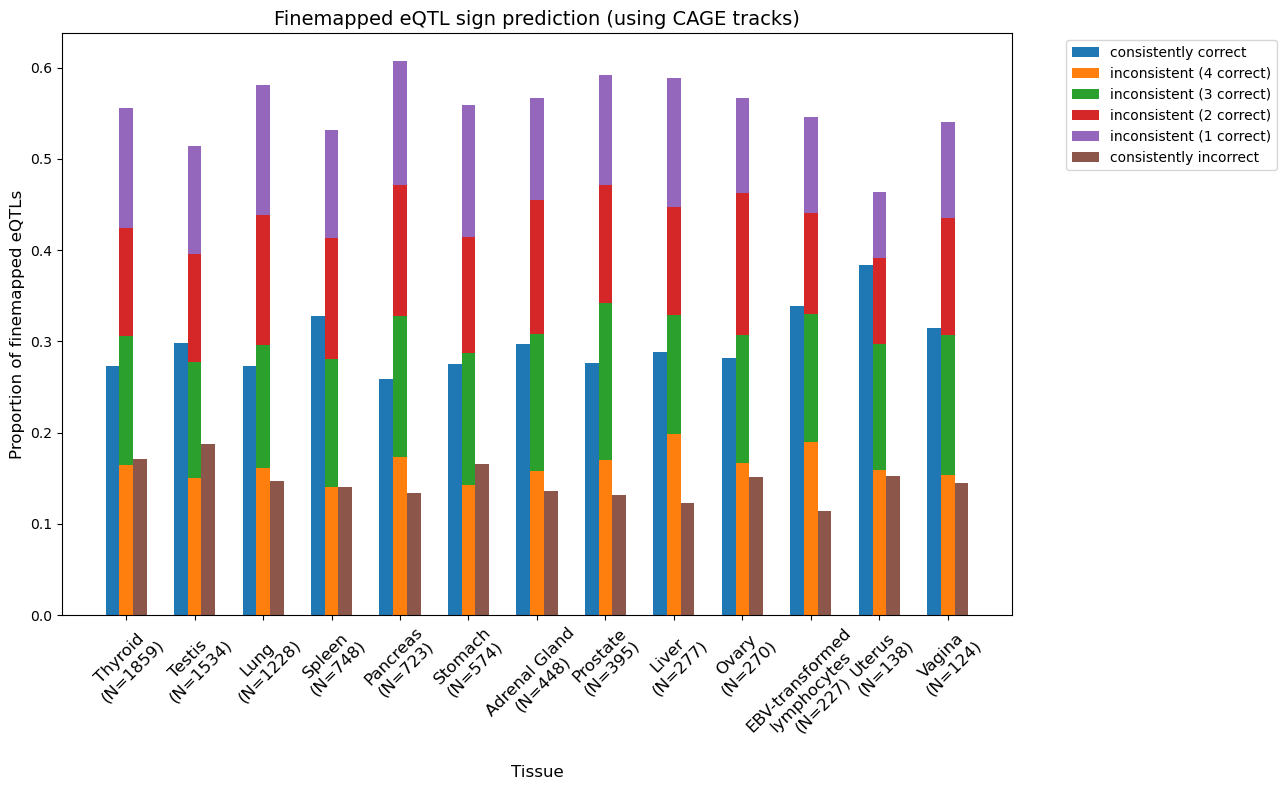

In [23]:
plot_sign_consistency_results(merged_eqtl_df, assay="CAGE")

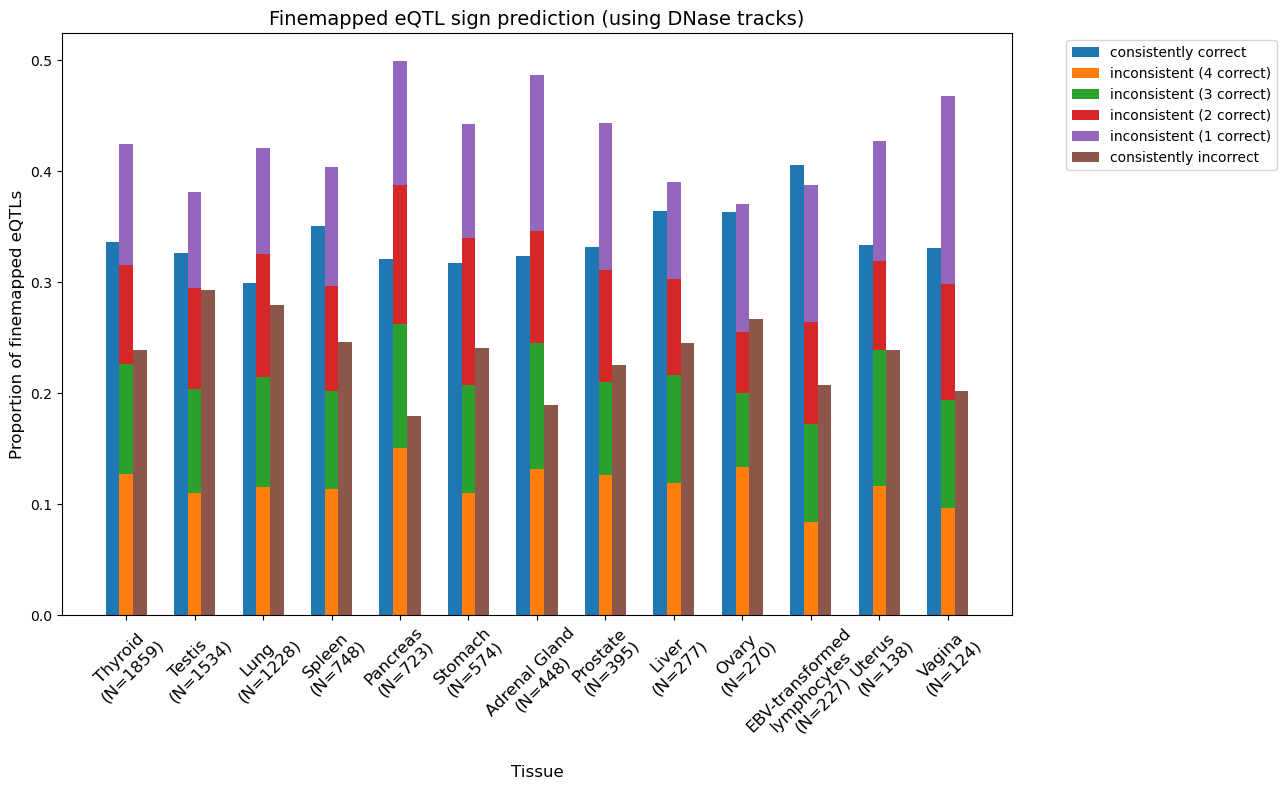

In [24]:
plot_sign_consistency_results(merged_eqtl_df, assay="DNase")

# Compare CAGE and DNase correctness

In [53]:
def compare_assay_correctness(eqtl_df: pd.DataFrame):
    eqtl_df = eqtl_df[eqtl_df["finemapped"]].copy()
    
    correctness = np.zeros((6, 6), dtype=int)
    for n_cage_correct, n_dnase_correct in zip(eqtl_df["n_correct_CAGE_SAD"], eqtl_df["n_correct_DNase_SAD"]):
        correctness[n_cage_correct, n_dnase_correct] += 1
    
    fig, ax = plt.subplots()
    sns.heatmap(correctness, annot=True, fmt="d", cbar=False, ax=ax)
    ax.set_xlabel("# replicates with correct DNase SAD sign")
    ax.set_ylabel("# replicates with correct CAGE SAD sign")
    ax.set_title("Comparison of assay correctness")
    plt.show()

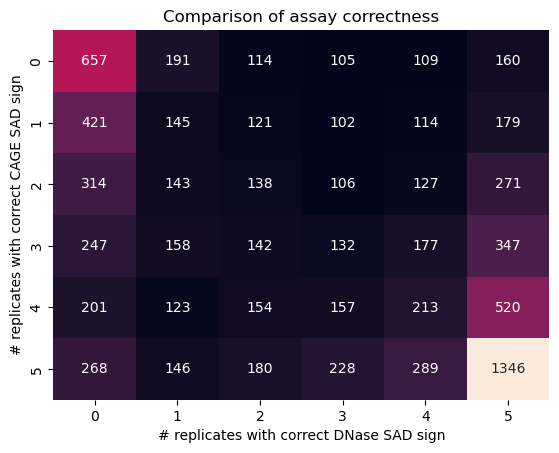

In [54]:
compare_assay_correctness(merged_eqtl_df)

# PIP by correctness

In [9]:
for n_cage_correct, correctness_df in merged_eqtl_df[merged_eqtl_df["finemapped"]].groupby("n_correct_CAGE_SAD"):
    pip_scores = correctness_df["pip"]
    print(n_cage_correct, pip_scores.mean(), pip_scores.std())

0 0.9816297049379727 0.02739624995039196
1 0.9817869240922318 0.027301478037089776
2 0.982249168137963 0.026313566556588126
3 0.983060634340047 0.026261897540836326
4 0.9840585776953487 0.025512217833515566
5 0.9850337833887943 0.025104041521663935
